In [1]:
# 1. Importação das bibliotecas necessárias
# Bibliotecas gerais
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
import seaborn as sns


from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler

from modelos import *


In [2]:
def carregar_e_preparar_dados(caminho_csv, coluna_target):
    """
    Função para carregar o dataset e separar em X (features) e y (rótulo).

    Args:
    - caminho_csv: caminho do arquivo CSV
    - coluna_target: nome da coluna que representa o rótulo

    Returns:
    - X_train, X_test, y_train, y_test: conjuntos de treino e teste
    """

    cols = ['NU_ANO','TP_FAIXA_ETARIA', 'TP_DEPENDENCIA_ADM_ESC', 
        'NPessoas', 'Escolaridade_Pai', 'Escolaridade_Mae', 'Renda', 'Computador',
        'Celular', 'Internet', f'{coluna_target}']

    #selecionando as colunas relevantes
    cols = ['NU_ANO','TP_FAIXA_ETARIA', 'TP_DEPENDENCIA_ADM_ESC', 
        'NPessoas', 'Escolaridade_Pai', 'Escolaridade_Mae', 'Renda', 'Computador',
        'Celular', 'Internet', f'{coluna_target}']

    df = pd.read_csv(caminho_csv, sep=',', usecols=cols)
    df = df[df['NU_ANO']> 2022]
    df = df.drop(columns=['NU_ANO'])

    oneHotdata = OneHotEncoder(handle_unknown='ignore', sparse_output=False).set_output(transform='pandas')
    oneHotdata = oneHotdata.fit_transform(df[['TP_DEPENDENCIA_ADM_ESC']])
    df = pd.concat([df, oneHotdata], axis=1)
    df = df.drop(columns=['TP_DEPENDENCIA_ADM_ESC'])
    novos_nomes = {
        'TP_DEPENDENCIA_ADM_ESC_1.0': 'Federal',
        'TP_DEPENDENCIA_ADM_ESC_2.0': 'Estadual',
        'TP_DEPENDENCIA_ADM_ESC_3.0': 'Municipal',
        'TP_DEPENDENCIA_ADM_ESC_4.0': 'Privada',
    }
    df.rename(columns=novos_nomes, inplace=True)


    # Separando variáveis independentes e dependente
    X = df.drop(columns=[coluna_target])
    y = df[coluna_target]

    # Dividindo em treino e teste
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


    #Normalização
    scaler = MinMaxScaler()
    X_train['TP_FAIXA_ETARIA'] = scaler.fit_transform(X_train[['TP_FAIXA_ETARIA']])
    X_test['TP_FAIXA_ETARIA'] = scaler.transform(X_test[['TP_FAIXA_ETARIA']])   #aqui não vai o fit, pois o teste não pode colar do treino
                    
    X_train['Renda'] = scaler.fit_transform(X_train[['Renda']])
    X_test['Renda'] = scaler.transform(X_test[['Renda']])   #aqui não vai o fit, pois o teste não pode colar do treino
                    
    X_train['NPessoas'] = scaler.fit_transform(X_train[['NPessoas']])
    X_test['NPessoas'] = scaler.transform(X_test[['NPessoas']])   #aqui não vai o fit, pois o teste não pode colar do treino
              
    X_train['Escolaridade_Mae'] = scaler.fit_transform(X_train[['Escolaridade_Mae']])
    X_test['Escolaridade_Mae'] = scaler.transform(X_test[['Escolaridade_Mae']])   #aqui não vai o fit, pois o teste não pode colar do treino

    X_train['Escolaridade_Pai'] = scaler.fit_transform(X_train[['Escolaridade_Pai']])
    X_test['Escolaridade_Pai'] = scaler.transform(X_test[['Escolaridade_Pai']])   #aqui não vai o fit, pois o teste não pode colar do treino


    return X_train, X_test, y_train, y_test, df

In [3]:
file = 'Data/enem_2011_2023.csv'  # Substitua pelo caminho do seu arquivo CSVASD
#variaveis que podem ser usadas com Y:
#Desempenho
#DesempenhoRedacao
#NOTA_FINAL
#NU_NOTA_REDACAO,

X_train, X_test, y_train, y_test, df = carregar_e_preparar_dados(file, 'Desempenho')
X_train

,TP_FAIXA_ETARIA,NPessoas,Escolaridade_Pai,Escolaridade_Mae,Renda,Computador,Celular,Internet,Federal,Estadual,Municipal,Privada
250477,0.111111,0.315789,0.166667,0.166667,0.050,0.0,1.0,0.0,0.0,1.0,0.0,0.0
247898,0.055556,0.157895,0.666667,0.666667,0.000,1.0,1.0,1.0,0.0,1.0,0.0,0.0
253220,0.055556,0.157895,0.833333,1.000000,0.250,1.0,1.0,1.0,0.0,0.0,0.0,1.0
247492,0.111111,0.157895,0.666667,0.166667,0.050,0.0,1.0,1.0,0.0,1.0,0.0,0.0
247003,0.055556,0.105263,0.666667,1.000000,0.100,1.0,1.0,1.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
255649,0.055556,0.105263,0.666667,0.833333,0.400,1.0,0.0,1.0,0.0,0.0,0.0,1.0
247621,0.111111,0.052632,0.833333,0.833333,0.125,1.0,1.0,1.0,0.0,0.0,0.0,1.0
243091,0.111111,0.105263,0.166667,0.666667,0.050,0.0,1.0,1.0,0.0,1.0,0.0,0.0
258026,0.166667,0.105263,0.000000,0.166667,0.000,1.0,1.0,0.0,0.0,1.0,0.0,0.0


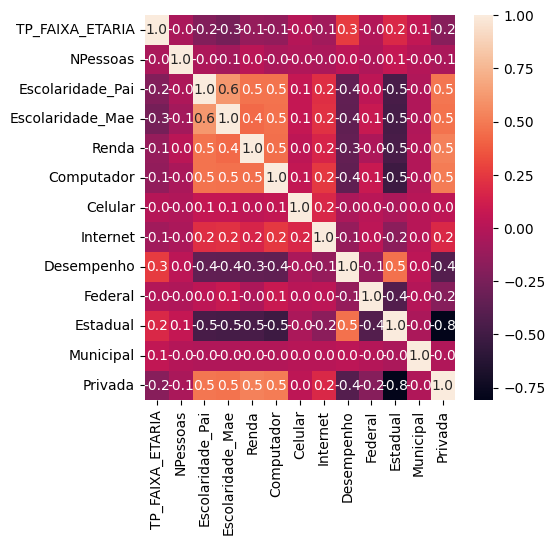

In [4]:
plt.figure(figsize=(5,5))
sns.heatmap(df.corr(), annot=True, fmt='.1f')
plt.show()

### PRIMEIRO VEJO AQUI, QUAL A PROFUNDIDADE IDEAL PARA NÃO OCORRER OVERFIT

max_depth tested:  1  2  3  4  5  6  7  8  

c:\GitMaria\MachineLearning\FinalProject\venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


9  10  11  12  13  14  

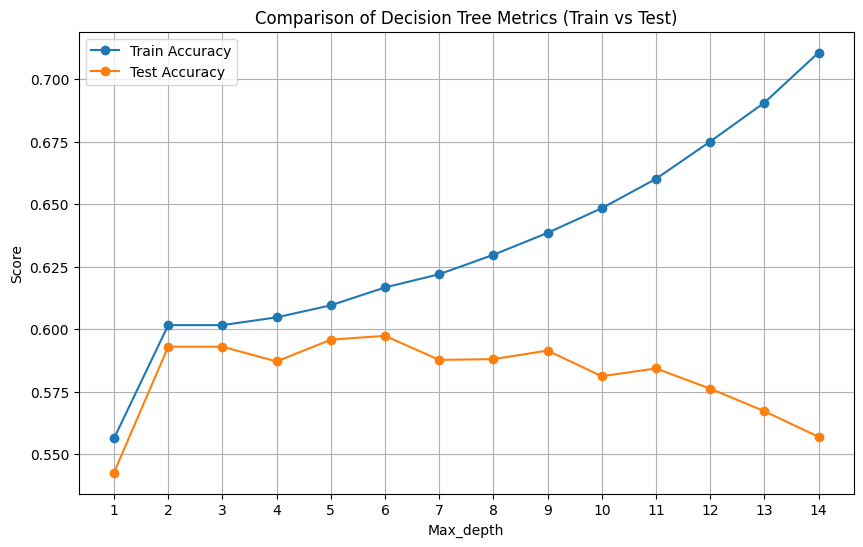

Best max_depth_tree: 6
Metrics for best max_depth: {'train_accuracy': 0.6166822139303483, 'test_accuracy': 0.5973258706467661, 'precision': 0.6111971818554512, 'recall': 0.5973258706467661, 'f1': 0.5631572726957693}


(6,
 {'train_accuracy': 0.6166822139303483,
  'test_accuracy': 0.5973258706467661,
  'precision': 0.6111971818554512,
  'recall': 0.5973258706467661,
  'f1': 0.5631572726957693})

In [5]:
best_depth_for_tree(X_train, X_test, y_train, y_test)

### APLICANDO  A ÁRVORE

Árvores de decisão nos ajudam a visualizar dados linearmente não separáveis

In [ ]:
modelo_arvore_decisao(X_train, X_test, y_train, y_test)

# SVM

SVM - Resultados
Melhores parâmetros: {'C': 10, 'gamma': 0.1}
Erro de treino (Ein): 0.4073
Erro de teste (Eout): 0.4294
Número total de vetores de suporte: 10372

Relatório de Classificação:
               precision    recall  f1-score   support

           1       0.62      0.51      0.56       844
           2       0.56      0.83      0.67      1648
           3       0.47      0.05      0.08       724

    accuracy                           0.57      3216
   macro avg       0.55      0.46      0.44      3216
weighted avg       0.56      0.57      0.51      3216



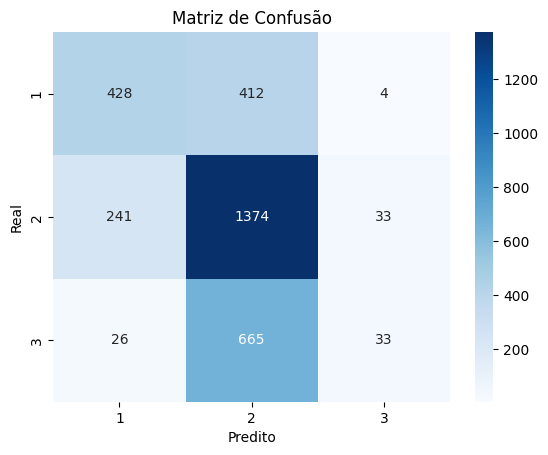

SVC(C=10, gamma=0.1, random_state=0)

In [ ]:
# modelo_svm(X_train, X_test, y_train, y_test)

# REDES NEURAIS

In [ ]:
input_dim = X_train.shape[1]
output_dim = len(np.unique(y_train))


modelo_rede_neural(X_train, X_test, y_train, y_test, input_dim, output_dim)

c:\GitMaria\MachineLearning\FinalProject\venv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


InvalidArgumentError: Graph execution error:

Detected at node compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits defined at (most recent call last):
  File "C:\Users\maria\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main

  File "C:\Users\maria\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code

  File "c:\GitMaria\MachineLearning\FinalProject\venv\lib\site-packages\ipykernel_launcher.py", line 18, in <module>

  File "c:\GitMaria\MachineLearning\FinalProject\venv\lib\site-packages\traitlets\config\application.py", line 1075, in launch_instance

  File "c:\GitMaria\MachineLearning\FinalProject\venv\lib\site-packages\ipykernel\kernelapp.py", line 739, in start

  File "c:\GitMaria\MachineLearning\FinalProject\venv\lib\site-packages\tornado\platform\asyncio.py", line 205, in start

  File "C:\Users\maria\AppData\Local\Programs\Python\Python310\lib\asyncio\base_events.py", line 603, in run_forever

  File "C:\Users\maria\AppData\Local\Programs\Python\Python310\lib\asyncio\base_events.py", line 1909, in _run_once

  File "C:\Users\maria\AppData\Local\Programs\Python\Python310\lib\asyncio\events.py", line 80, in _run

  File "c:\GitMaria\MachineLearning\FinalProject\venv\lib\site-packages\ipykernel\kernelbase.py", line 545, in dispatch_queue

  File "c:\GitMaria\MachineLearning\FinalProject\venv\lib\site-packages\ipykernel\kernelbase.py", line 534, in process_one

  File "c:\GitMaria\MachineLearning\FinalProject\venv\lib\site-packages\ipykernel\kernelbase.py", line 437, in dispatch_shell

  File "c:\GitMaria\MachineLearning\FinalProject\venv\lib\site-packages\ipykernel\ipkernel.py", line 362, in execute_request

  File "c:\GitMaria\MachineLearning\FinalProject\venv\lib\site-packages\ipykernel\kernelbase.py", line 778, in execute_request

  File "c:\GitMaria\MachineLearning\FinalProject\venv\lib\site-packages\ipykernel\ipkernel.py", line 449, in do_execute

  File "c:\GitMaria\MachineLearning\FinalProject\venv\lib\site-packages\ipykernel\zmqshell.py", line 549, in run_cell

  File "c:\GitMaria\MachineLearning\FinalProject\venv\lib\site-packages\IPython\core\interactiveshell.py", line 3077, in run_cell

  File "c:\GitMaria\MachineLearning\FinalProject\venv\lib\site-packages\IPython\core\interactiveshell.py", line 3132, in _run_cell

  File "c:\GitMaria\MachineLearning\FinalProject\venv\lib\site-packages\IPython\core\async_helpers.py", line 128, in _pseudo_sync_runner

  File "c:\GitMaria\MachineLearning\FinalProject\venv\lib\site-packages\IPython\core\interactiveshell.py", line 3336, in run_cell_async

  File "c:\GitMaria\MachineLearning\FinalProject\venv\lib\site-packages\IPython\core\interactiveshell.py", line 3519, in run_ast_nodes

  File "c:\GitMaria\MachineLearning\FinalProject\venv\lib\site-packages\IPython\core\interactiveshell.py", line 3579, in run_code

  File "C:\Users\maria\AppData\Local\Temp\ipykernel_29168\1997188191.py", line 5, in <module>

  File "c:\GitMaria\MachineLearning\FinalProject\modelos.py", line 232, in modelo_rede_neural

  File "c:\GitMaria\MachineLearning\FinalProject\venv\lib\site-packages\keras\src\utils\traceback_utils.py", line 117, in error_handler

  File "c:\GitMaria\MachineLearning\FinalProject\venv\lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 371, in fit

  File "c:\GitMaria\MachineLearning\FinalProject\venv\lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 219, in function

  File "c:\GitMaria\MachineLearning\FinalProject\venv\lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 132, in multi_step_on_iterator

  File "c:\GitMaria\MachineLearning\FinalProject\venv\lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 113, in one_step_on_data

  File "c:\GitMaria\MachineLearning\FinalProject\venv\lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 60, in train_step

  File "c:\GitMaria\MachineLearning\FinalProject\venv\lib\site-packages\keras\src\trainers\trainer.py", line 383, in _compute_loss

  File "c:\GitMaria\MachineLearning\FinalProject\venv\lib\site-packages\keras\src\trainers\trainer.py", line 351, in compute_loss

  File "c:\GitMaria\MachineLearning\FinalProject\venv\lib\site-packages\keras\src\trainers\compile_utils.py", line 690, in __call__

  File "c:\GitMaria\MachineLearning\FinalProject\venv\lib\site-packages\keras\src\trainers\compile_utils.py", line 699, in call

  File "c:\GitMaria\MachineLearning\FinalProject\venv\lib\site-packages\keras\src\losses\loss.py", line 67, in __call__

  File "c:\GitMaria\MachineLearning\FinalProject\venv\lib\site-packages\keras\src\losses\losses.py", line 33, in call

  File "c:\GitMaria\MachineLearning\FinalProject\venv\lib\site-packages\keras\src\losses\losses.py", line 2246, in sparse_categorical_crossentropy

  File "c:\GitMaria\MachineLearning\FinalProject\venv\lib\site-packages\keras\src\ops\nn.py", line 1964, in sparse_categorical_crossentropy

  File "c:\GitMaria\MachineLearning\FinalProject\venv\lib\site-packages\keras\src\backend\tensorflow\nn.py", line 744, in sparse_categorical_crossentropy

Received a label value of 3 which is outside the valid range of [0, 3).  Label values: 2 3 3 3 2 2 2 2 1 2 2 2 2 2 2 1 2 2 2 1 3 2 1 1 1 3 2 2 3 1 3 1
	 [[{{node compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits}}]] [Op:__inference_multi_step_on_iterator_2574]